In [9]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import warnings
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
warnings.simplefilter('ignore')
%matplotlib inline

In [10]:
def epoch(ts):
    pattern = '%d-%m-%Y'
    epochtime = int(time.mktime(time.strptime(ts, pattern)))
    
    return epochtime

def time_log(line):
    start = line.rfind("(")+1
    middle = line.rfind(",")
    end = line.rfind(")")
    t1 = epoch(line[start:middle])
    t2 = epoch(line[middle+1:end])
    tr = [t1,t2]
    
    return tr

def time_diff(ts, te):
    
    t1_y = int(ts.split("-")[0])
    t1_m = int(ts.split("-")[1])
    t1_d = int(ts.split("-")[2])
        
    #yyyy-mm-dd
    
    t2_y = int(te.split("-")[0])
    t2_m = int(te.split("-")[1])
    t2_d = int(te.split("-")[2])   
    
    d1 = date(t1_y, t1_m, t1_d)
    d2 = date(t2_y, t2_m, t2_d)
    delta = d1 - d2
    time_diff = abs(delta.days)
    
    return time_diff

def real_sol():
    sol ={}
    l1 = ['flood,Colorado,2013-09-09','blizzard,New York,2014-02-11','hurricane,North Carolina,2014-07-01']
    l2 = ['tornado,Oklahoma,2013-05-20','blizzard,Massachusetts,2014-02-06','earthquake,California,2014-08-24']    
    l3 = ['hurricane,Florida,2013-06-09','earthquake,California,2014-03-17','blizzard,New York,2014-11-13']
    sol['pos1,pos7,pos6'] = l1
    sol['pos4,pos9,pos5'] = l2
    sol['pos2,pos3,pos8'] = l3
    
    return sol

In [11]:
def each_effort(log_dict, algo, data, xkey, time, nd_list, location_list, nd_time, sol):
    
    # log effort part
    
    if(len(log_dict['actions']['x'])== 0):
        log_dict['actions']['x'].append(1)
    else:
        log_dict['actions']['x'].append(log_dict['actions']['x'][-1]+1)
    
    log_dict['time_elapsed']['x'].append(time)     
    
    if(len(log_dict[xkey]['x'])!=0):
        log_dict[xkey]['x'].append(log_dict[xkey]['x'][-1]+1)
    else:
        log_dict[xkey]['x'].append(1)
    
    
    # log results part
    
    ylist = ['nd_precision', 'location_precision', 'nd_recall', 'location_recall','nd_time_error']
    
    nd_sol = [x.split(',')[0] for x in sol]
    location_sol = [x.split(',')[1] for x in sol]
    ndtime_sol = [x.split(',')[2] for x in sol]
    # log result part
    
    nd_p = 0.000
    nd_r = 0.000
    location_p = 0.000
    location_r = 0.000
    #time_err = 2190.000
    time_err = 0.000 
    
    if(len(nd_list)!=0):
        nd_corr = 0        
        location_corr = 0
        time_err_current = 0.000
        for i in range(len(nd_list)):
            if(nd_list[i] in nd_sol):
                nd_corr += 1
            if(location_list[i] in location_sol):
                location_corr += 1
            #if((nd_list[i] in nd_sol) and (location_list[i] in location_sol)): 
            #    k = nd_list.index(nd_list[i])
            #    time_err_current += time_diff(nd_time[i], ndtime_sol[k]) - 730
            if((nd_list[i] in nd_sol) and (location_list[i] in location_sol)): 
                k = nd_list.index(nd_list[i])
                time_err_current += time_diff(nd_time[i], ndtime_sol[k])
            else:
                time_err_current += 730
        
        nd_p = float(nd_corr)/len(nd_list)
        nd_r = float(nd_corr)/3.0
        
        location_p = float(location_corr)/len(location_list)
        location_r = float(location_corr)/3.0
        
        time_err += time_err_current
            
    log_dict[xkey]['nd_precision'].append(nd_p)
    log_dict['actions']['nd_precision'].append(nd_p)
    log_dict['time_elapsed']['nd_precision'].append(nd_p)
    log_dict[xkey]['nd_recall'].append(nd_r)
    log_dict['actions']['nd_recall'].append(nd_r)
    log_dict['time_elapsed']['nd_recall'].append(nd_r)
    
    log_dict[xkey]['location_precision'].append(location_p)
    log_dict['actions']['location_precision'].append(location_p)
    log_dict['time_elapsed']['location_precision'].append(location_p)
    log_dict[xkey]['location_recall'].append(location_r)
    log_dict['actions']['location_recall'].append(location_r)
    log_dict['time_elapsed']['location_recall'].append(location_r)   
    
    log_dict[xkey]['nd_time_error'].append(time_err)
    log_dict['actions']['nd_time_error'].append(time_err)
    log_dict['time_elapsed']['nd_time_error'].append(time_err)

    return log_dict

In [12]:
def each_log(logDir, logFile, real_sol, user):
    
    fieldlist = ['query', 'slider', 'ZoomLevel', 'MouseDrag', 'checking_tweet',
                 'checking_filter', 'time_elapsed', 'actions']    
    ylist = ['nd_precision', 'nd_recall', 'location_precision', 'location_recall','nd_time_error'] 
    
    nds = []
    locations = [] 
    ndtimes = []
    
    log_dict = {} # save log infor
    
    for field in fieldlist:
        log_dict[field] = {}
        log_dict[field]['x'] = []
        for y in ylist:
            log_dict[field][y] = []
            
    log = logDir + logFile
    
    with open(log, "r") as f:
        i = 0
        ts = 0
        tsq = 0
        tq = 0
        algo = 'good'
        data = 'good'
        final = 0
        for line in f:
            i += 1
            line_split = line.split('\t')
            if('START' in line_split[1]):
                algo = line_split[2]
                data = line_split[-1][:-1]
                log_dict['algo']= algo
                log_dict['data']= data
                sol = real_sol[data]
                ts = float(line_split[0])/1000
                
            elif('Query_Execution' in line_split[1]):
                teq = float(line_split[0])/1000
                tq += (teq - tsq)
            
            elif('query' in line_split[1]):
                xkey = 'query'
                tsq = float(line_split[0])/1000
                time_com = tsq - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)
                    
            elif('slider' in line_split[1]):
                xkey = 'slider'
                time_com = float(line_split[0])/1000 - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)
                
            elif('ZoomLevel' in line_split[1]):
                xkey = 'ZoomLevel'
                time_com = float(line_split[0])/1000 - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)                
            
            elif('MouseDrag' in line_split[1]):
                xkey = 'MouseDrag'
                time_com = float(line_split[0])/1000 - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol) 
            
            elif('clicking_tweet' in line_split[1]):
                xkey = 'checking_tweet'
                time_com = float(line_split[0])/1000 - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol) 
                                    
            elif(('clicking_bbox' in line_split[1]) or ('adding_filter' in line_split[1])
                 or ('removing_filter' in line_split[1])):
                xkey = 'checking_filter'
                time_com = float(line_split[0])/1000 - ts - tq                
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)   
                
            elif('final_answer' in line_split[1]):
                nds.append(line_split[3])
                ndtimes.append(line_split[5])
                locations.append(line_split[7][:-1])
                time_com = float(line_split[0])/1000 - ts - tq
                if(user):
                    for xkey in fieldlist[:-2]:
                        log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)
                else:
                    log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)
                
        f.close()
    
    return log_dict

In [13]:
#log_dir = "experiment_logs/"
#filename = 'logs_4_baseline.txt'
#rs = real_sol()
#one_dict = each_log(log_dir, filename, rs)

In [14]:
def total_log_initial():
    fieldlist = ['query', 'slider', 'ZoomLevel', 'MouseDrag','checking_tweet',
                'checking_filter', 'time_elapsed', 'actions']
    
    ylist = ['nd_precision', 'nd_recall', 'location_precision', 'location_recall','nd_time_error']
    
    algolist = ['baseline','kmeans','filters']
    datalist = ['pos1,pos7,pos6','pos4,pos9,pos5','pos2,pos3,pos8']
    
    keylist = []
    for algo in algolist:
        for data in datalist:
            keylist.append((algo, data))
    
    total_dict = {}
    
    for field in fieldlist:
        total_dict[field] = {} 
        total_dict[field]['x'] = {}
        for algo in algolist:
            for key in keylist:             
                total_dict[field]['x'][key] = []
        for y in ylist:
            total_dict[field][y] = {}
            for key in keylist:            
                total_dict[field][y][key] = []

    return total_dict

def total_log_writing(total_dict, log_dict, norm):
    fieldlist = ['query', 'slider', 'ZoomLevel', 'MouseDrag', 'checking_tweet',
                'checking_filter','time_elapsed', 'actions']
    
    ylist = ['nd_precision', 'nd_recall', 'location_precision', 'location_recall','nd_time_error']
    
    algo = log_dict['algo']
    data = log_dict['data']
    key = (algo, data)
    
    for f in fieldlist:
        unnorm_x = log_dict[f]['x']
        if(len(unnorm_x)!=0):
            if (f=='time_elapsed' and norm=='Yes'):
                norm_x = [(float(ele))/float(max(unnorm_x)) for ele in unnorm_x]
                total_dict[f]['x'][key].append(norm_x)
            else:
                total_dict[f]['x'][key].append(unnorm_x)
        
        for y in ylist:            
            total_dict[f][y][key].append(log_dict[f][y])
    
    return total_dict

In [15]:
def interp(X, Y, long_X):
    xs = set(X)
    xp = list(long_X - xs) #Note long_X is Set
    y_eval = [float(0.000)]*len(Y)
    if(len(Y)!= 0):
        yp = np.interp(xp, X, Y)
        y_eval = [yv for _,yv in sorted(zip(X,Y)+zip(xp, yp))]
    
    return y_eval

def plot_algo(total_dict, filename, field_plots, user):
    if(field_plots== "global"):
        fieldlist = ['time_elapsed', 'actions']
    else:
        fieldlist = ['query', 'slider', 'ZoomLevel', 'MouseDrag', 'checking_tweet','checking_filter']   
    ylist = ['nd_precision', 'nd_recall', 'location_precision', 'location_recall','nd_time_error']
    
    algolist = ['baseline','kmeans','filters']
    datalist = ['pos1,pos7,pos6','pos4,pos9,pos5','pos2,pos3,pos8']
    
    color_algo = ['blue','green','red']
    
    pp = PdfPages(filename)
    k = 1
    for y in ylist:     
        for f in fieldlist:
            fig = plt.figure(k)
            ax = plt.axes()
            ax.grid(True)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            for i in range(len(algolist)):
                algo = algolist[i]
                if not ((algo=='baseline') and (f=='checking_filter')):
                    keylist = []                
                    for data in datalist:
                        keylist.append((algo, data))              
                    unflatten_x = []
                    unflatten_y = []
                    lx = []
                    ly = []
                    for key in keylist:
                        lx = total_dict[f]['x'][key]
                        ly = total_dict[f][y][key]
                        unflatten_x += lx
                        unflatten_y += ly

                    unflatten_x = filter(None, unflatten_x)
                    unflatten_y = filter(None, unflatten_y)  #remove empty nested-list 

                    if (len(unflatten_x)!=0):
                        x_plot_set = set(reduce(lambda x1,x2: x1+x2,unflatten_x))
                        x_plot = list(x_plot_set)
                        x_plot.sort()
                        y_total = []

                        for j in range(len(unflatten_x)):
                            y_total_current = interp(unflatten_x[j], unflatten_y[j], x_plot_set)
                            y_total.append(y_total_current)

                        if(len(x_plot)!=0):
                            ym = np.mean(y_total, axis = 0, dtype = float)

                            if(user):
                                plt.plot(x_plot, ym, linestyle='-', color=color_algo[i])                             
                                for k in range(len(y_total)):
                                    plt.plot(x_plot, y_total[k], linestyle=':', color=color_algo[i]) 
                                
                            else:
                                plt.plot(x_plot, ym, linestyle='-', color=color_algo[i], label=algo+'_mean')
                                ys = np.std(y_total, axis= 0, dtype=float)
                                yl = ym - ys
                                yu = ym + ys
                                plt.fill_between(x_plot, yl, yu, alpha=0.1, edgecolor='', 
                                                 facecolor=color_algo[i], linewidth=0.0)                            
                            
            plt.title(f + ' VS '+ y)
            if (f == "time_elapsed"):
                plt.xlabel(f + " (Sec)")
            else:
                plt.xlabel(f)
            if (y == "nd_time_error"):
                plt.ylabel(y + " (Day)")
            else:
                plt.ylabel(y)
            plt.legend()
            k+= 1
            
            #plt.savefig(f+"_"+y, format='eps')
            plt.savefig(pp, format='pdf')
            plt.show()
    
    pp.close()
    print k

### In each plot, solid line and dot line are used for mean and mean +/- standard deviation
### Blue is for baseline algorithm,  green is for kmeans, and red is for filters.
### Also, note that all completion time is squashed into (0.0, 1.0]

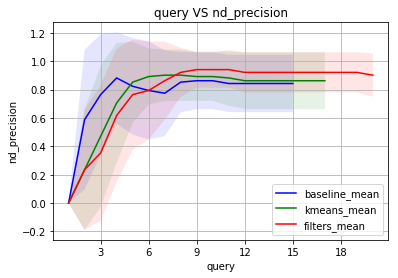

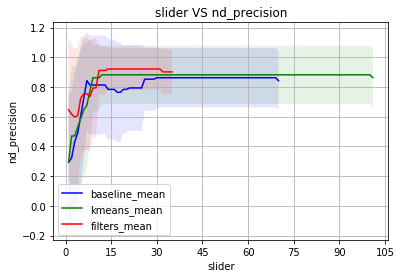

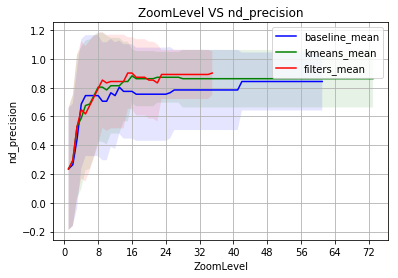

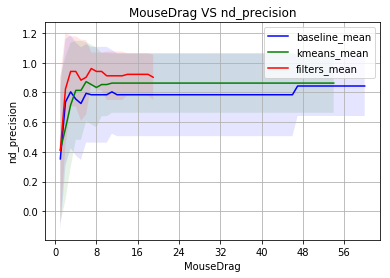

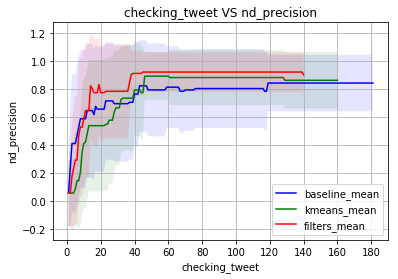

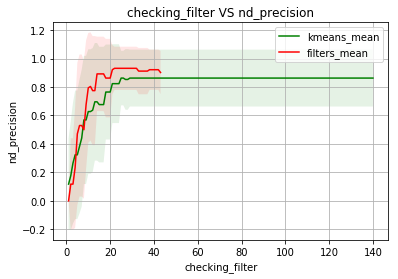

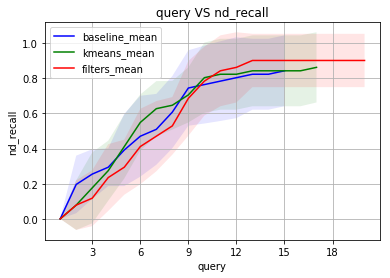

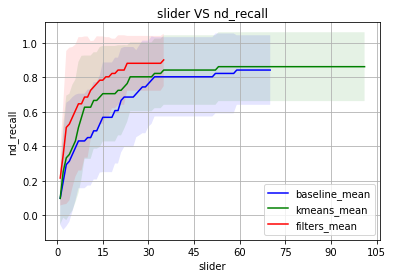

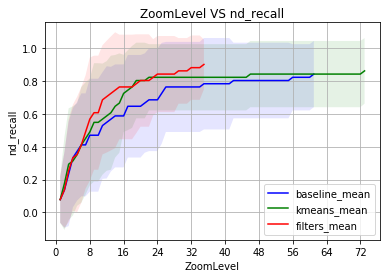

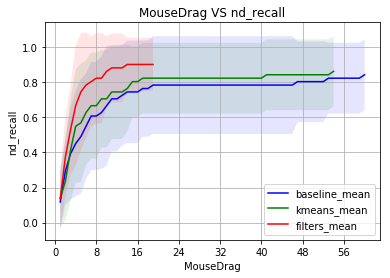

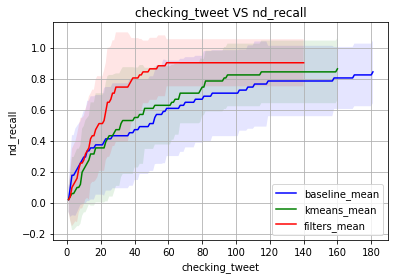

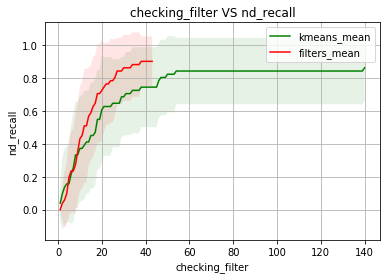

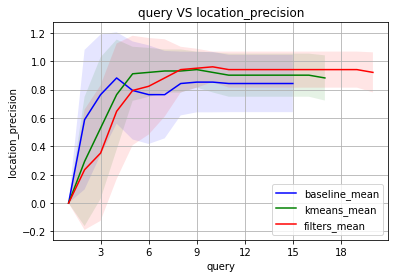

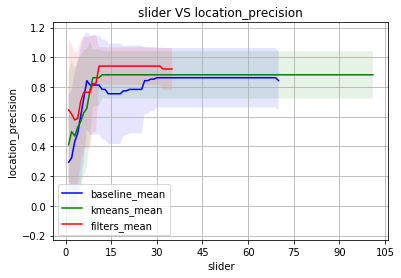

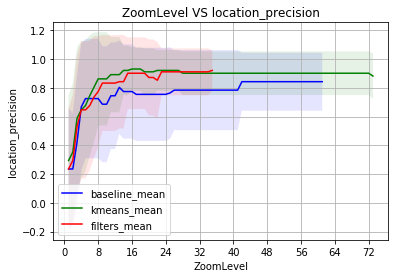

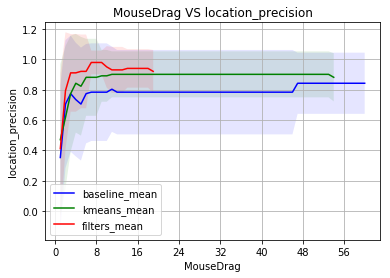

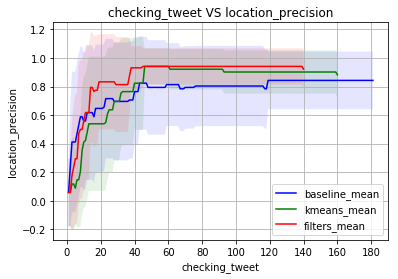

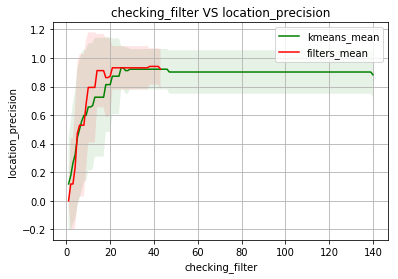

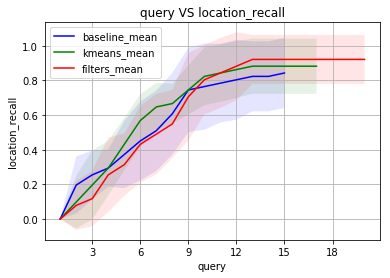

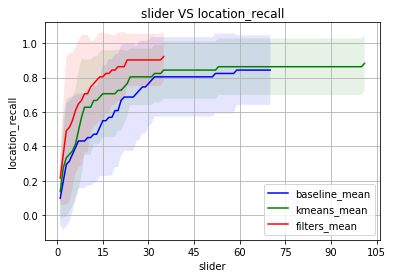

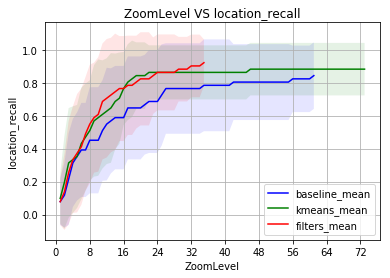

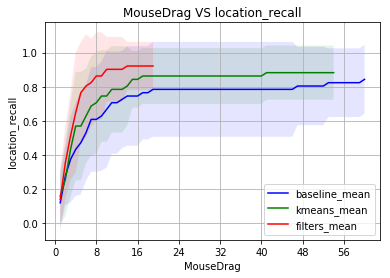

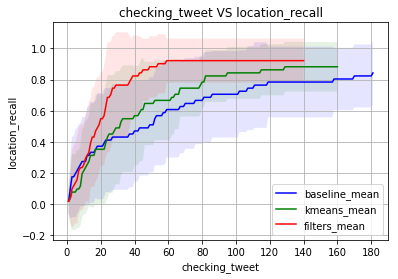

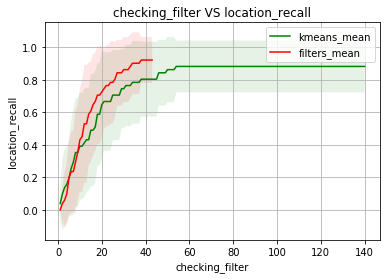

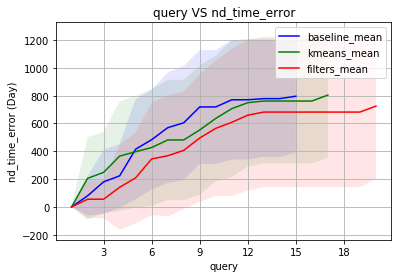

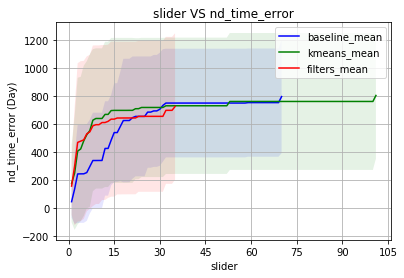

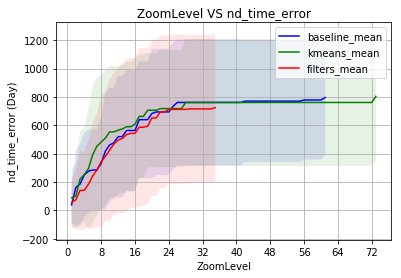

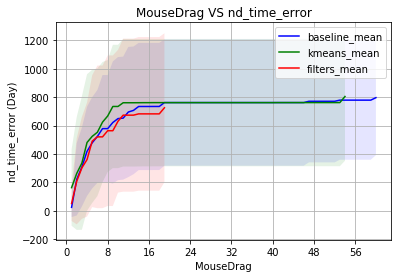

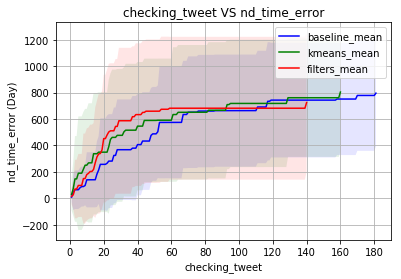

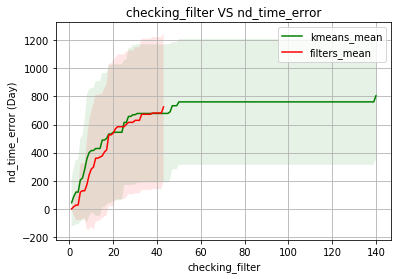

31


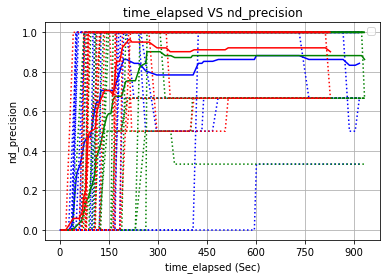

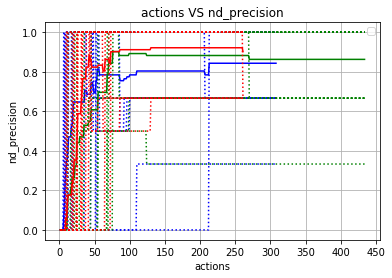

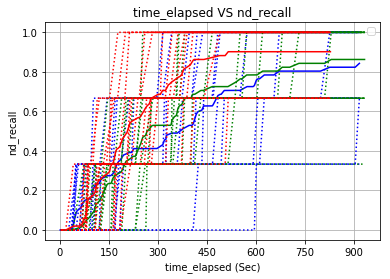

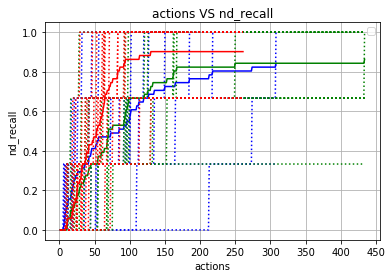

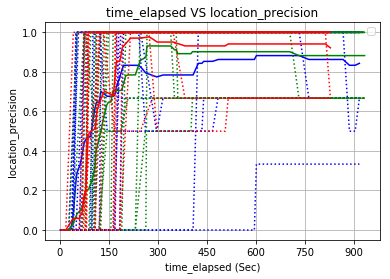

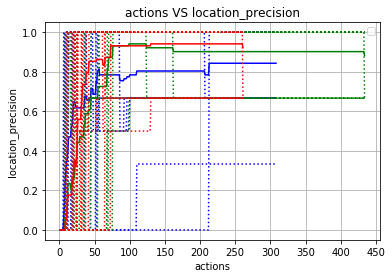

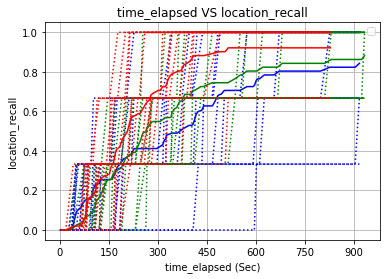

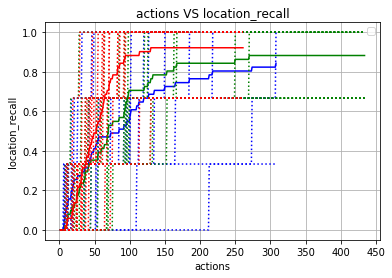

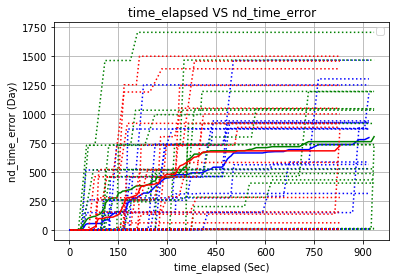

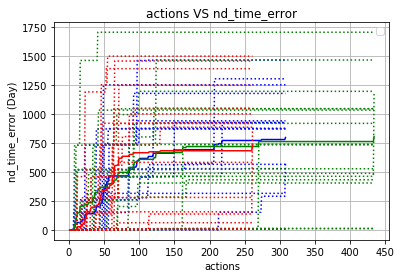

17


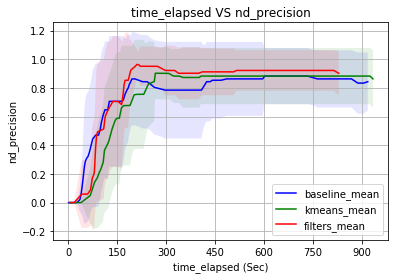

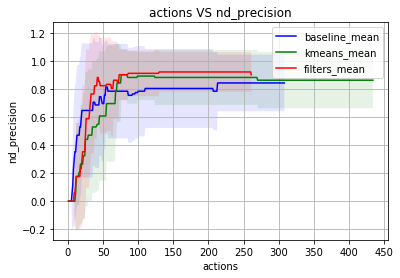

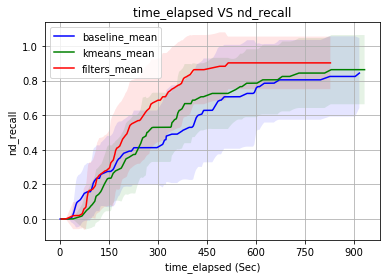

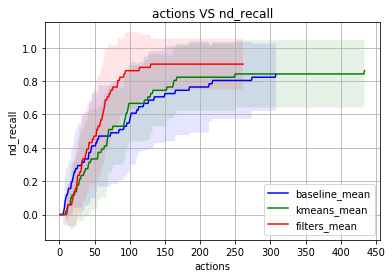

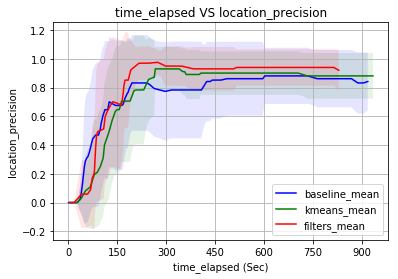

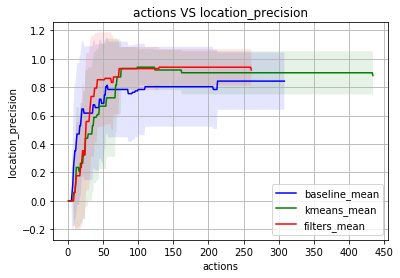

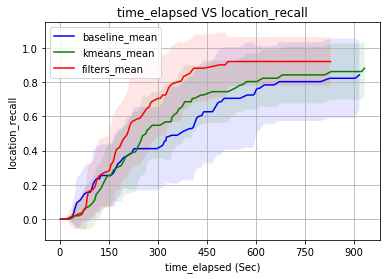

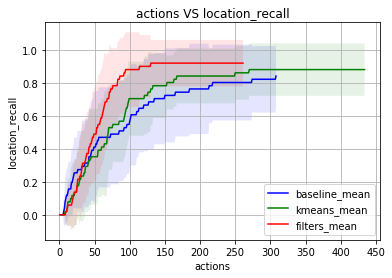

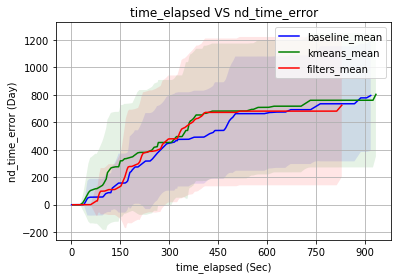

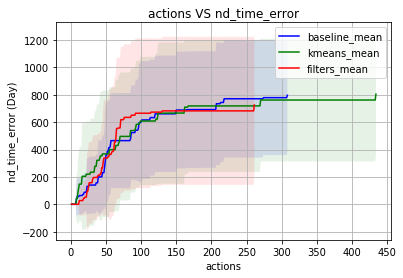

11


In [16]:
log_dir = "experiment_logs/"
#log_dir = "one_log/"
rs = real_sol()
pdfname = "actions.pdf"

total_dict = total_log_initial()
for filename in os.listdir(log_dir):
    one_dict = each_log(log_dir, filename, rs, True)
    #total_dict = total_log_writing(total_dict, one_dict, 'Yes')
    total_dict = total_log_writing(total_dict, one_dict, 'No')

#total_dict
plot_algo(total_dict, pdfname, "actions", False)

pdfname = "global_user.pdf"
total_dict = total_log_initial()
for filename in os.listdir(log_dir):
    one_dict = each_log(log_dir, filename, rs, False)
    #total_dict = total_log_writing(total_dict, one_dict, 'Yes')
    total_dict = total_log_writing(total_dict, one_dict, 'No')
plot_algo(total_dict, pdfname, "global", True)    

pdfname = "global.pdf"
plot_algo(total_dict, pdfname, "global", False)